# Figure 2b. Representative simulation examples.

Representative simulation examples illustrating limitations of competing methods: (i) methods under “one-causal” assumption fail to detect causal signals with heterogeneous effects and (ii) spurious detection of non-causal variants with strongest marginal effect; (iii) COLOC (V5) shows reduced sensitivity to weak causal effects in GWAS.

## 1. Heterogeneous effects for two causal variants

When analyzing multiple causal variants, it's important to consider that they may exhibit heterogeneous effects across different contexts, populations, or individuals. 

### ColocBoost identify two CoS including two true causal variants.

In [1]:
library(tidyverse)
library(colocboost)
load("data/Heterogeneous_Effect.rda")
data <- Heterogeneous_Effect
X <- data$X
Y <- data$Y
data$variant

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1]  622 1275

In [2]:
res <- colocboost(X = X, Y = Y)
res$cos_details$cos$cos_index

Starting checking the input data.

Starting gradient boosting algorithm.

Boosting iterations for outcome 1 converge after 51 iterations!

Boosting iterations for outcome 2 converge after 56 iterations!

Starting assemble analyses and results summary.



$`cos1:y1_y2`
[1] 622

$`cos2:y1_y2`
 [1] 1293 1270 1288 1287 1305 1300 1275 1271 1273 1290 1291

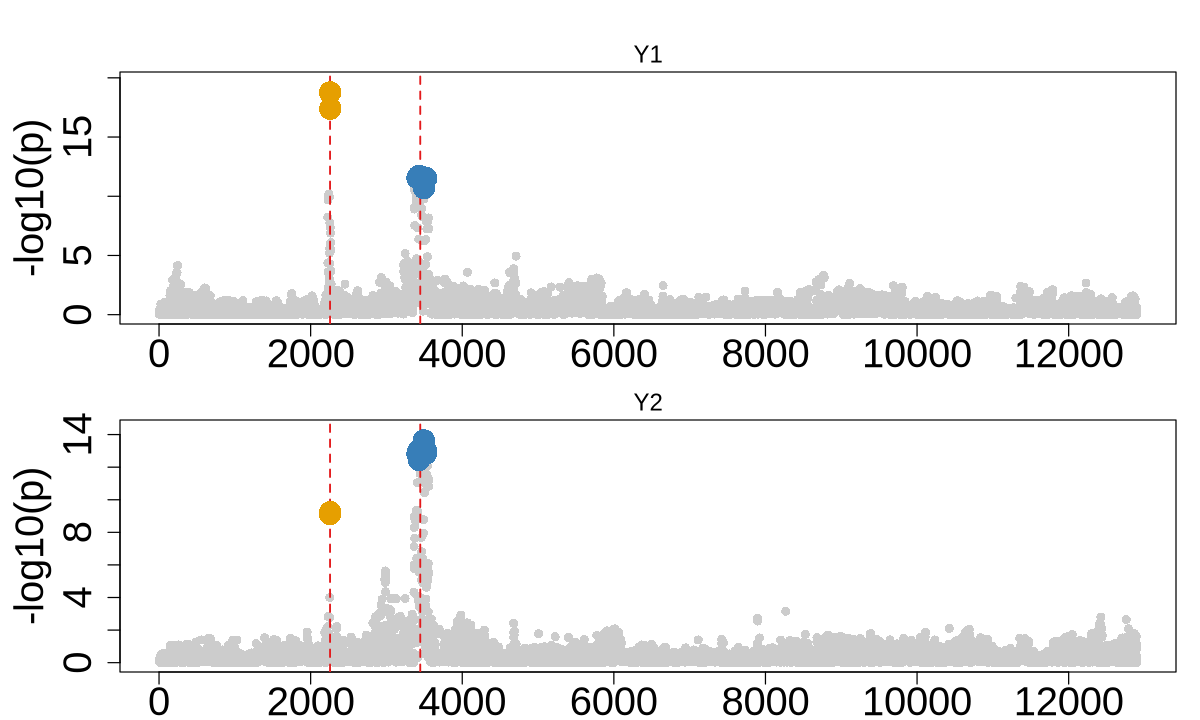

In [5]:
options(repr.plot.width = 10, repr.plot.height = 6)
colocboost_plot(res, plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant))

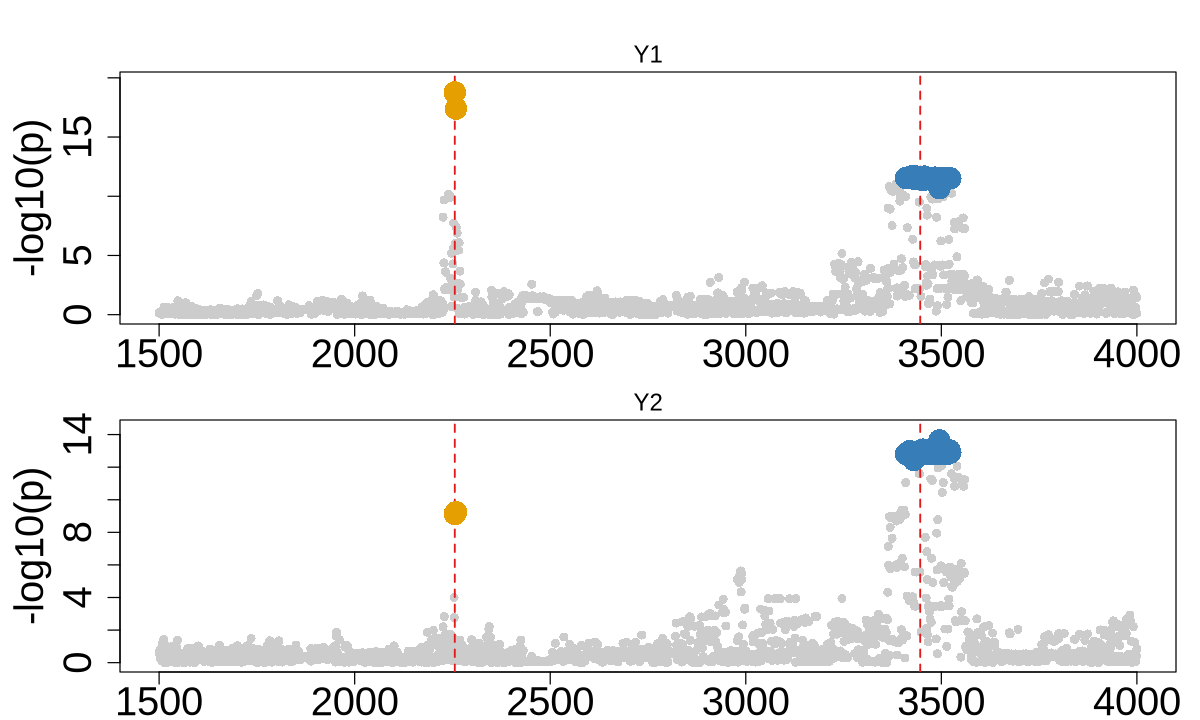

In [6]:
colocboost_plot(res, plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant), grange = c(0:2000))

In [7]:
res$cos_details$cos_purity$min_abs_cor

,cos1:y1_y2,cos2:y1_y2
cos1:y1_y2,0.9869088,0.0125171
cos2:y1_y2,0.0125171,0.9840258


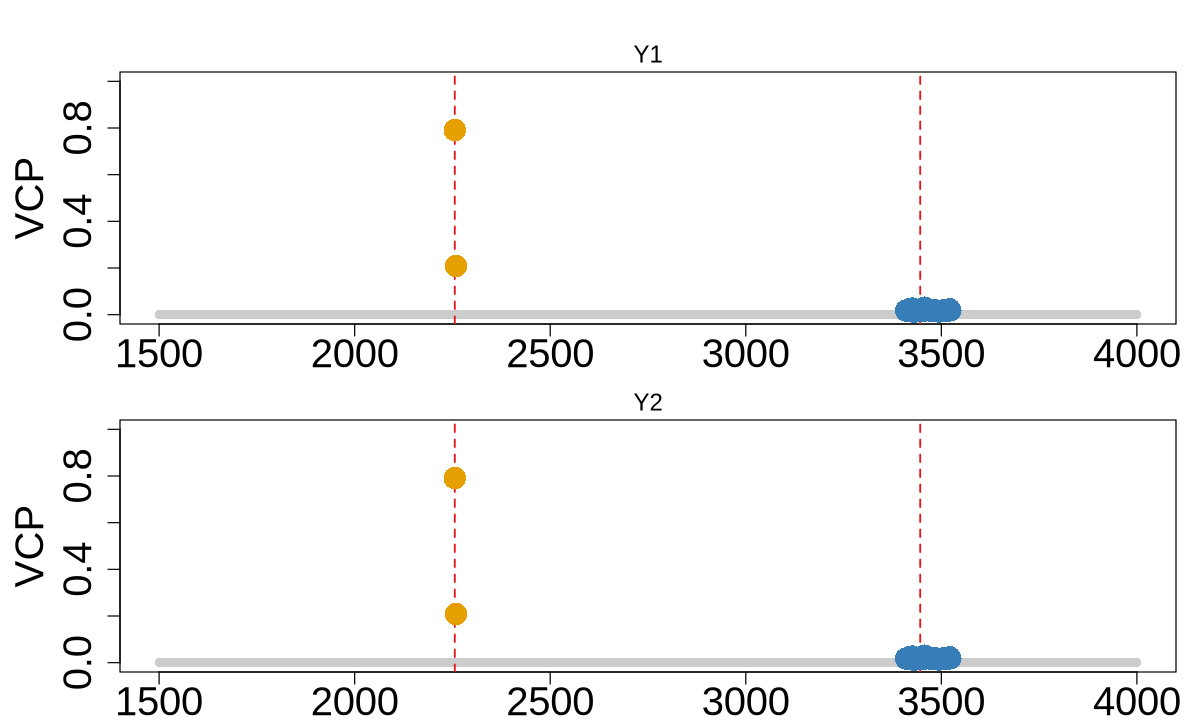

In [8]:
colocboost_plot(res, y = "vcp", plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant), 
                grange = c(0:2000))

### HyPrColoc

In [9]:
library(hyprcoloc)
betas = sebetas = matrix(NA, nrow = ncol(X), ncol = 2) 
for (i in 1:2){
    x <- scale(X)
    y <- scale(Y[,i])
    rr <- susieR::univariate_regression(x, y)
    betas[,i] = rr$betahat
    sebetas[, i] <- rr$sebetahat
}
traits <- c(1:2)
rsid <- paste0("snp", c(1:ncol(X)))
colnames(betas) <- colnames(sebetas) <- traits
rownames(betas) <- rownames(sebetas) <- rsid
res_hyprcoloc <- hyprcoloc(betas, sebetas, trait.names=traits, snp.id=rsid, snpscores = TRUE)

Warning message:
“replacing previous import ‘Matrix::tcrossprod’ by ‘Rmpfr::tcrossprod’ when loading ‘hyprcoloc’”
Warning message:
“replacing previous import ‘Matrix::crossprod’ by ‘Rmpfr::crossprod’ when loading ‘hyprcoloc’”
Warning message:
“replacing previous import ‘Matrix::.__C__atomicVector’ by ‘Rmpfr::.__C__atomicVector’ when loading ‘hyprcoloc’”


In [10]:
res_hyprcoloc$results

iteration,traits,posterior_prob,regional_prob,candidate_snp,posterior_explained_by_snp,dropped_trait
<dbl>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>,<chr>
1,None,NA,1,NA,NA,1


In [11]:
res_hyprcoloc %>% str

List of 1
 $ results:'data.frame':	1 obs. of  7 variables:
  ..$ iteration                 : num 1
  ..$ traits                    : chr "None"
  ..$ posterior_prob            : logi NA
  ..$ regional_prob             : num 1
  ..$ candidate_snp             : logi NA
  ..$ posterior_explained_by_snp: num NA
  ..$ dropped_trait             : chr "1"
 - attr(*, "class")= chr "hyprcoloc"


### COLOC (one causal assumption)

In [12]:
library(coloc)
LD <- get_cormat(X)
colnames(LD) <- rownames(LD) <- 1:ncol(X)
MAF <- colMeans(X)/2 %>% as.numeric
D1 <- list("beta" = betas[,1], "varbeta" = sebetas[,1]^2,
           "N" = nrow(X), "sdY" = sd(unlist(data$Y[,1])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(X), "position" = 1:ncol(X))
D2 <- list("beta" = betas[,2], "varbeta" = sebetas[,2]^2,
           "N" = nrow(X), "sdY" = sd(unlist(data$Y[,2])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(X), "position" = 1:ncol(X))
my.res <- coloc.abf(dataset1=D1, dataset2=D2)

This is coloc version 5.2.3

Warning message in adjust_prior(p1, nrow(df1), "1"):
“p1 * nsnps >= 1, setting p1=1/(nsnps + 1)”
Warning message in adjust_prior(p2, nrow(df2), "2"):
“p2 * nsnps >= 1, setting p2=1/(nsnps + 1)”


PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.76e-21  4.33e-09  4.04e-13  9.93e-01  6.84e-03 
[1] "PP abf for shared variant: 0.684%"


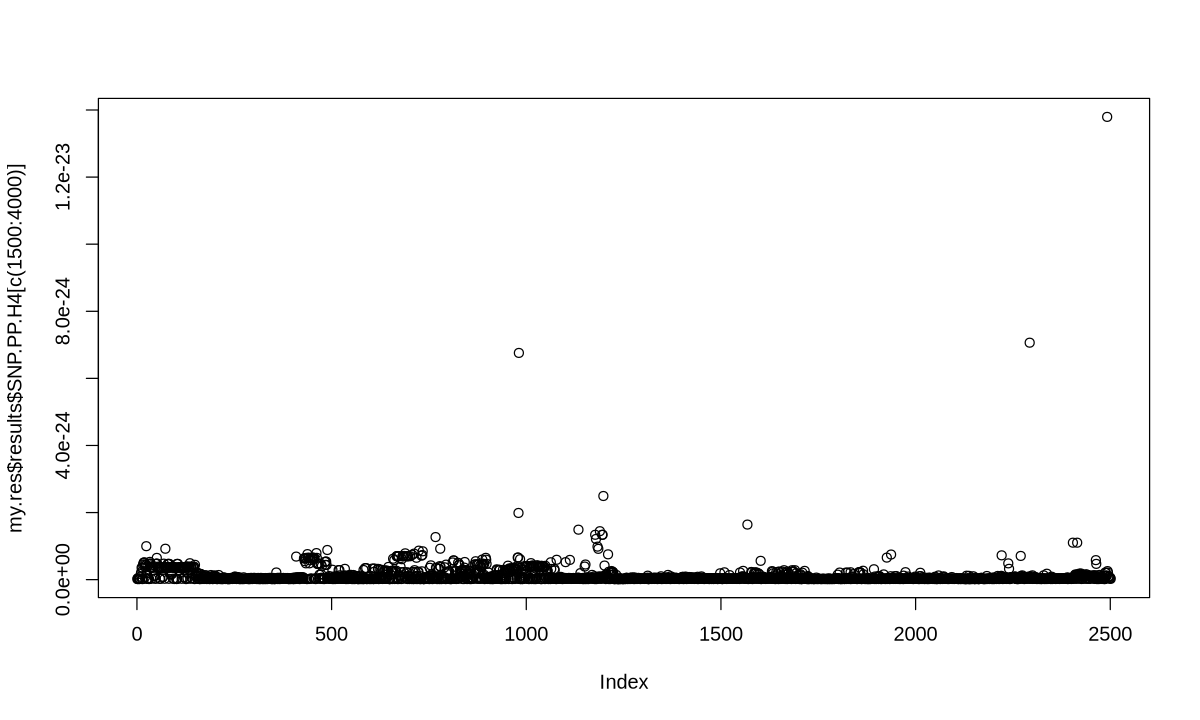

In [13]:
plot(my.res$results$SNP.PP.H4[c(1500:4000)])

### COLOC (V5)

In [16]:
library(susieR)
out_p <- runsusie(D1)
out_e <- runsusie(D2)
out_coloc = coloc.susie(out_e, out_p)

running max iterations: 100

	converged: TRUE

running max iterations: 100

	converged: TRUE



In [18]:
out_coloc$summary

nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
12900,3495,2256,4.890181e-21,1.140795e-12,4.286644e-09,0.999999996,2.924359e-11,1,1
12900,2256,2256,9.904029e-19,4.439301e-15,8.681693e-07,0.001895203,9.981039e-01,2,1
12900,3495,3408,1.921831e-17,4.483300e-09,5.255216e-10,0.120836772,8.791632e-01,1,2
12900,2256,3408,8.156886e-12,3.656176e-08,2.230487e-04,0.999775096,1.818970e-06,2,2


In [19]:
o <- order(out_coloc$results$SNP.PP.H4.row2,decreasing=TRUE)
cs <- cumsum(out_coloc$results$SNP.PP.H4.row2[o])
w <- which(cs > 0.95)[1]
cos1 <- out_coloc$results[o,][1:w,]$snp
cos1

[1] "2256"

In [20]:
o <- order(out_coloc$results$SNP.PP.H4.row3,decreasing=TRUE)
cs <- cumsum(out_coloc$results$SNP.PP.H4.row3[o])
w <- which(cs > 0.95)[1]
cos2 <- out_coloc$results[o,][1:w,]$snp
cos2

[1] "3425" "3426" "3457" "3521" "3419" "3480" "3453" "3437" "3495" "3416"
[11] "3484" "3523" "3410" "3411" "3414" "3415" "3417" "3420" "3421" "3422"
[21] "3423" "3424" "3432" "3435" "3439" "3440" "3449" "3450" "3451" "3452"
[31] "3454" "3455" "3456" "3458" "3472" "3476" "3479" "3481" "3482" "3485"
[41] "3486" "3504" "3508" "3510" "3511" "3512" "3516" "3447" "3446" "3494"
[51] "3428" "3438"

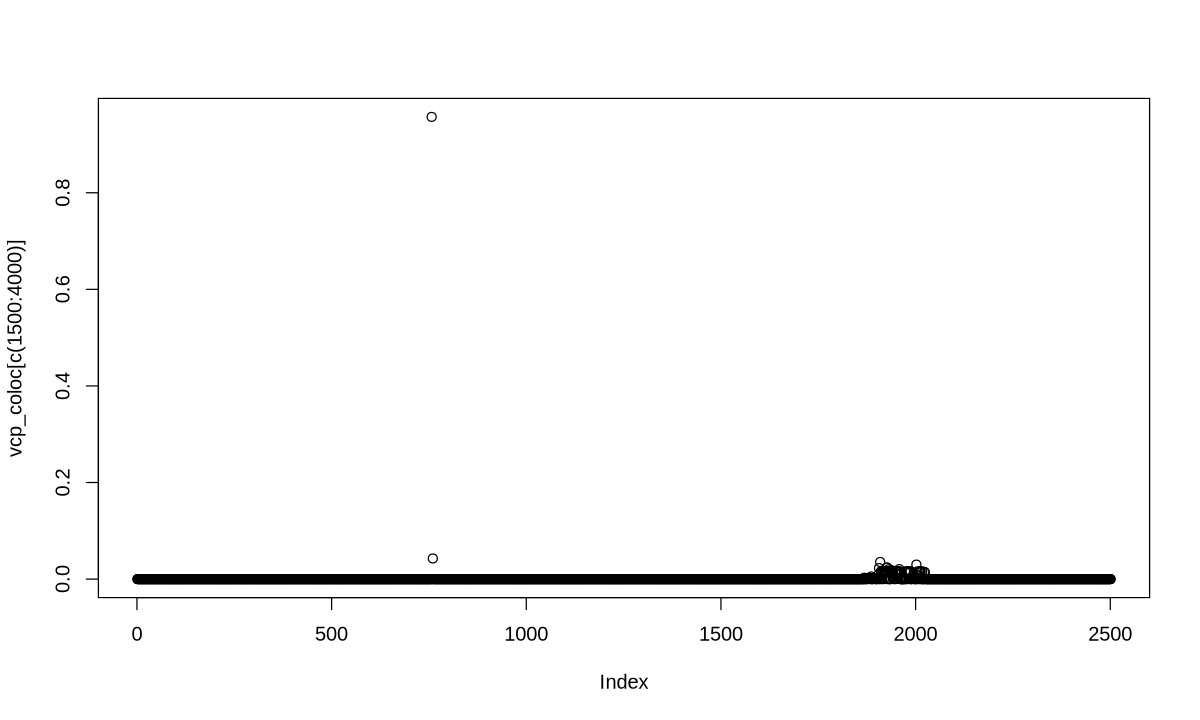

In [34]:
vcp_coloc <- 1 - (1-out_coloc$results$SNP.PP.H4.row1)*(1-out_coloc$results$SNP.PP.H4.row4)
plot(vcp_coloc[c(1500:4000)])

### MOLOC

In [49]:
library(moloc)
moloc_input <- lapply(1:2, function(cnt){
    tibble(SNP = 1:ncol(data$X), BETA = betas[,cnt],
           SE = sebetas[,cnt], N = nrow(data$X), MAF = MAF)
})
res_moloc <- moloc_test(listData = moloc_input)

Use default priors: 1e-04,1e-05

Mean estimated sdY from data1: 0.560918402515816

Mean estimated sdY from data2: 0.561003724043599

Use prior variances of 0.01 0.1 0.5

Use prior variances of 0.01 0.1 0.5

Best SNP per trait a: 2256

Probability that trait a colocalizes with at least one other trait = 0.0067

Best SNP per trait b: 2256

Probability that trait b colocalizes with at least one other trait = 0.0067

Best SNP per trait ab: 2256

Probability that trait ab colocalizes with at least one other trait = 0.0067



In [50]:
res_moloc$priors_lkl_ppa

,prior,sumbf,logBF_locus,PPA
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.00e-04,37.56061,28.09563,4.648440e-09
"a,b",1.00e-08,65.95099,47.02103,9.933272e-01
b,1.00e-04,28.39039,18.92540,4.838694e-13
ab,1.00e-05,54.04022,44.57524,6.672820e-03
zero,9.99e-01,0.00000,0.00000,2.264332e-21


In [51]:
res_moloc$best_snp

,coloc_ppas,best.snp.coloc
,<dbl>,<chr>
a,0.00667282,2256
b,0.00667282,2256
ab,0.00667282,2256


## 2. Non-causal strongest marginal effect

In [52]:
library(colocboost)
library(tidyverse)
load("data/Non_Causal_Strongest_Marginal.rda")
data <- Non_Causal_Strongest_Marginal
X <- data$X
Y <- data$Y
data$variant

[1] 654 858

In [53]:
res <- colocboost(X = X, Y = Y)
res$cos_details$cos$cos_index

Starting checking the input data.

Starting gradient boosting algorithm.

Boosting iterations for outcome 1 converge after 50 iterations!

Boosting iterations for outcome 2 converge after 56 iterations!

Starting assemble analyses and results summary.



$`cos1:y1_y2`
 [1] 654 721 761 797 673 677 756 720 740 678 773 777

$`cos2:y1_y2`
[1] 858 865 851 886 876 854 885

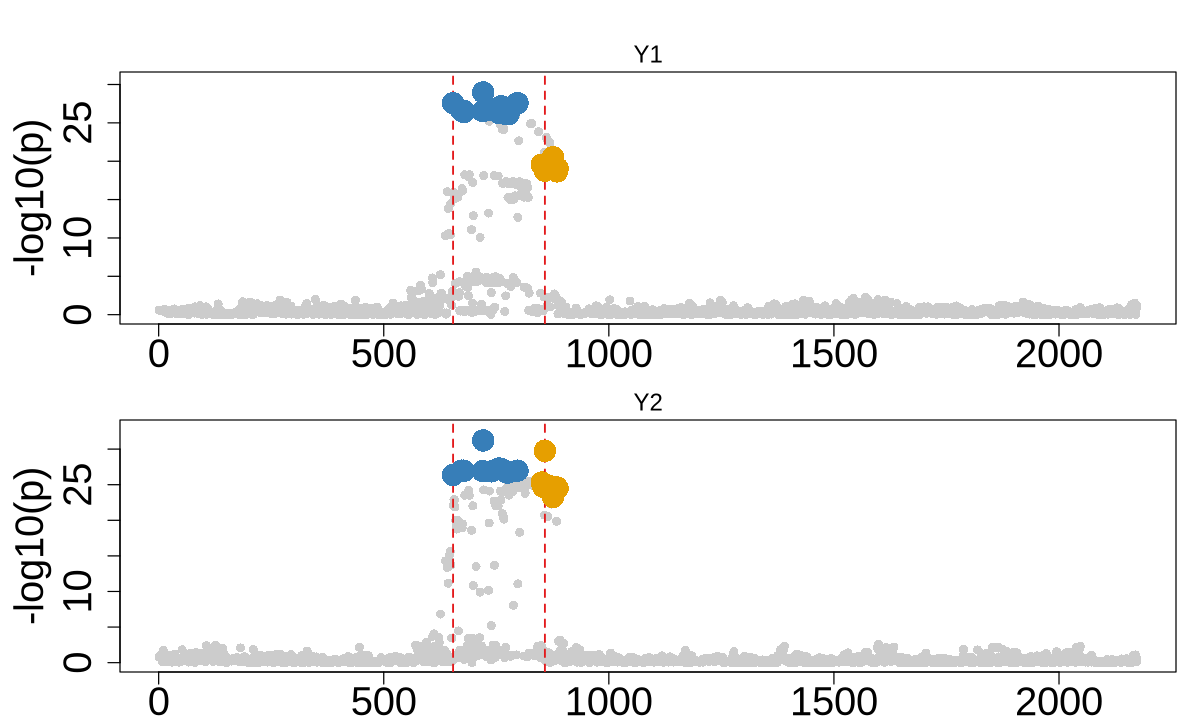

In [54]:
options(repr.plot.width = 10, repr.plot.height = 6)
colocboost_plot(res, plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant))

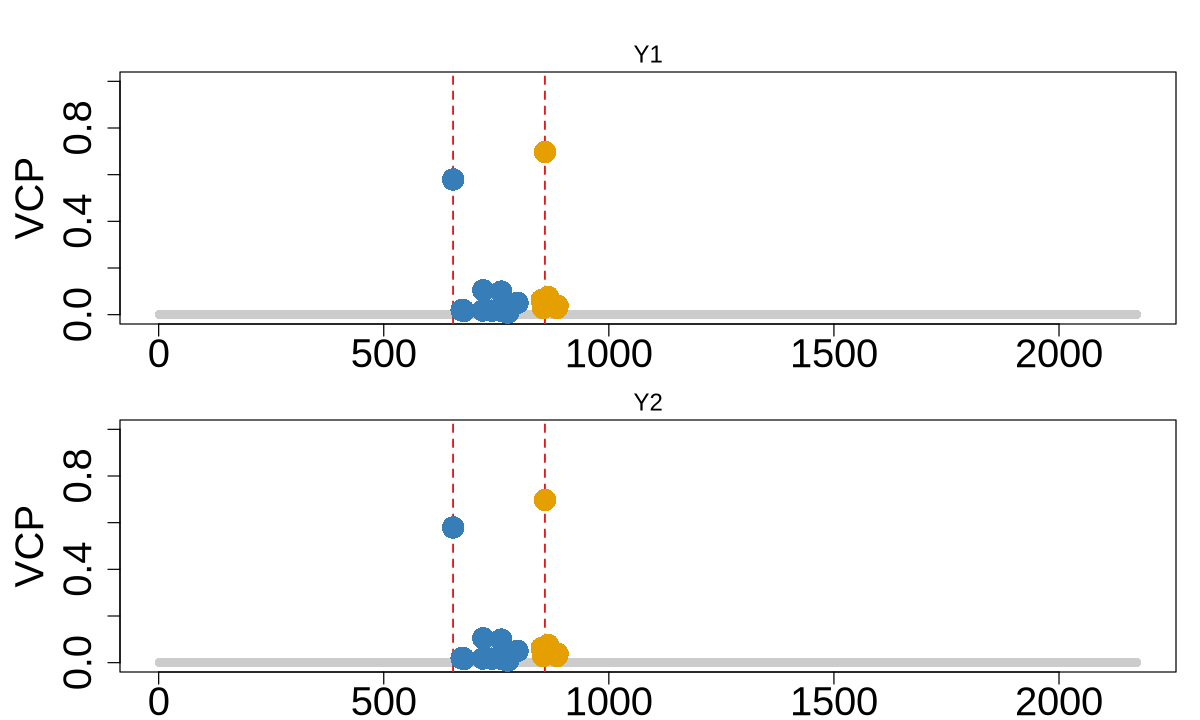

In [55]:
colocboost_plot(res, y = "vcp", plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant))

In [56]:
res$cos_details$cos_purity$min_abs_cor

,cos1:y1_y2,cos2:y1_y2
cos1:y1_y2,0.8666675,0.2562119
cos2:y1_y2,0.2562119,0.7613753


### HyPrColoc

In [57]:
library(hyprcoloc)
betas = sebetas = matrix(NA, nrow = ncol(X), ncol = 2) 
for (i in 1:2){
    x <- scale(X)
    y <- scale(Y[,i])
    rr <- susieR::univariate_regression(x, y)
    betas[,i] = rr$betahat
    sebetas[, i] <- rr$sebetahat
}
traits <- c(1:2)
rsid <- paste0("snp", c(1:ncol(X)))
colnames(betas) <- colnames(sebetas) <- traits
rownames(betas) <- rownames(sebetas) <- rsid
res_hyprcoloc <- hyprcoloc(betas, sebetas, trait.names=traits, snp.id=rsid, snpscores = TRUE)

In [58]:
res_hyprcoloc$results

iteration,traits,posterior_prob,regional_prob,candidate_snp,posterior_explained_by_snp,dropped_trait
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
1,"1, 2",0.9995,1,snp721,1,NA


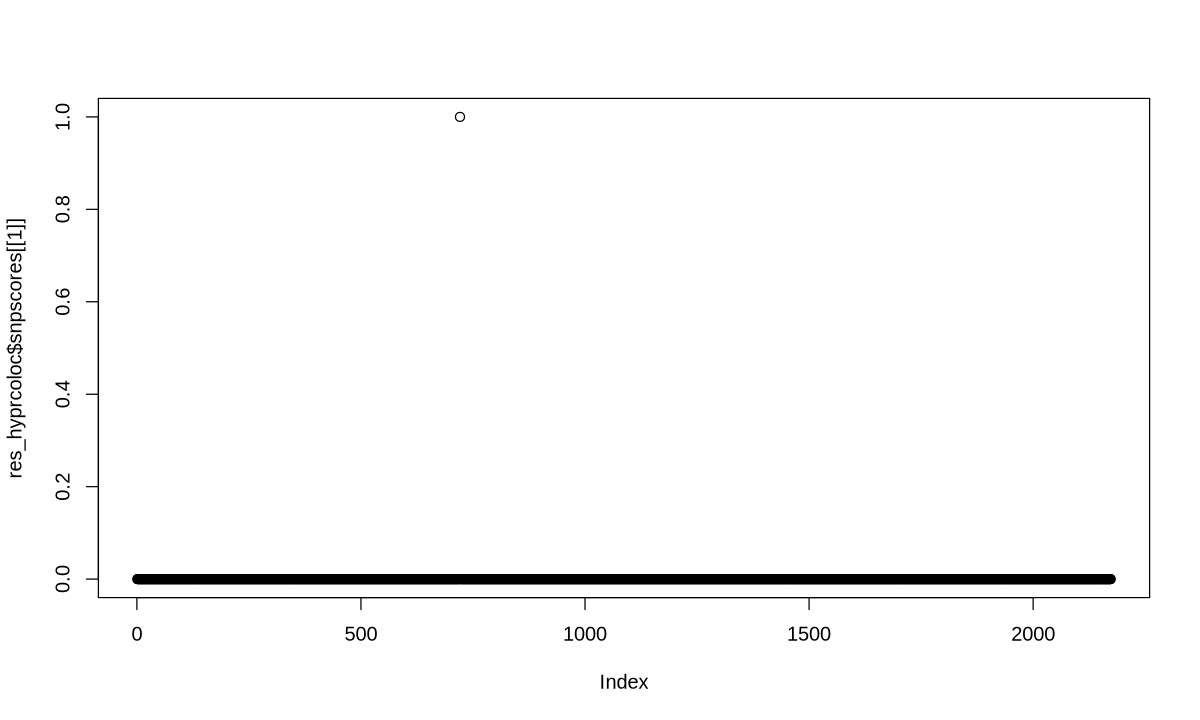

In [59]:
plot(res_hyprcoloc$snpscores[[1]])

### COLOC (one causal assumption)

In [60]:
library(coloc)
LD <- get_cormat(data$X)
colnames(LD) <- rownames(LD) <- 1:ncol(data$X)
MAF <- colMeans(data$X)/2 %>% as.numeric
D1 <- list("beta" = betas[,1], "varbeta" = sebetas[,1]^2,
           "N" = nrow(data$X), "sdY" = sd(unlist(data$Y[,1])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(data$X), "position" = 1:ncol(data$X))
D2 <- list("beta" = betas[,2], "varbeta" = sebetas[,2]^2,
           "N" = nrow(data$X), "sdY" = sd(unlist(data$Y[,2])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(data$X), "position" = 1:ncol(data$X))
my.res <- coloc.abf(dataset1=D1, dataset2=D2)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 6.41e-51  2.21e-28  3.44e-26  1.86e-04  1.00e+00 
[1] "PP abf for shared variant: 100%"


In [61]:
o <- order(my.res$results$SNP.PP.H4,decreasing=TRUE)
cs <- cumsum(my.res$results$SNP.PP.H4[o])
w <- which(cs > 0.95)[1]
my.res$results[o,][1:w,]$snp

[1] "721"

In [62]:
pph4.snp <- my.res$results$SNP.PP.H4[order(my.res$results$position,decreasing=FALSE)]

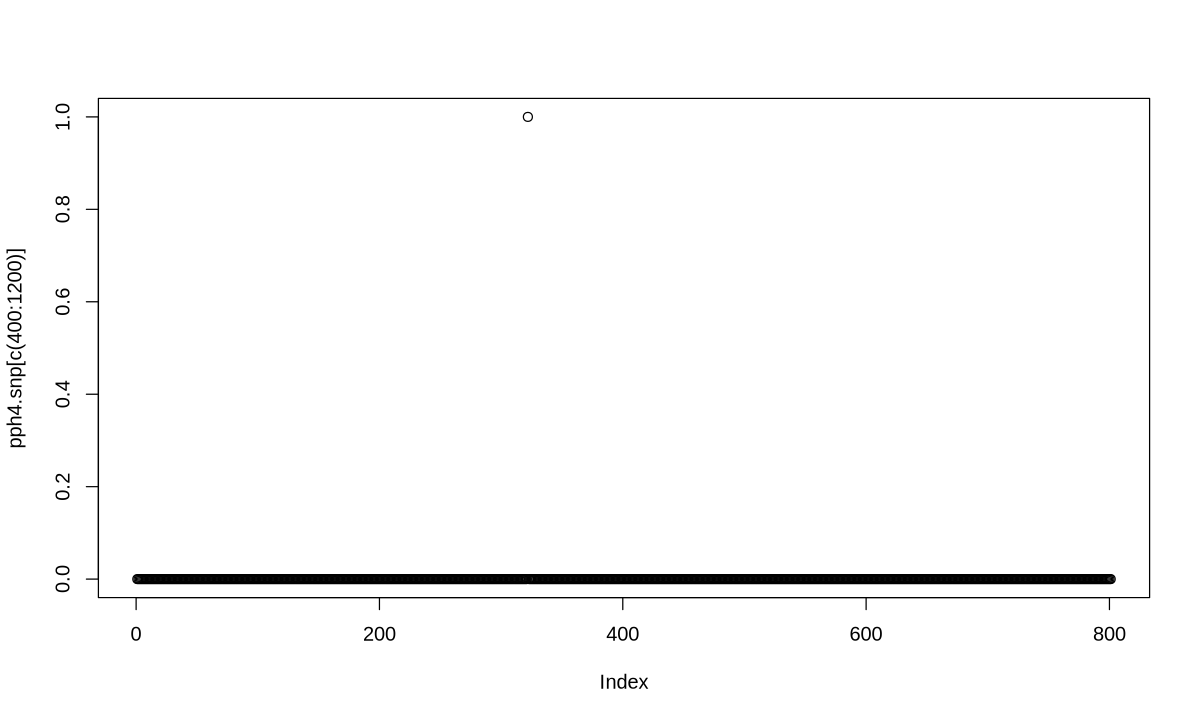

In [63]:
plot(pph4.snp[c(400:1200)])

### COLOC (V5)

In [66]:
library(susieR)
out_p <- runsusie(D1)
out_e <- runsusie(D2)
out_coloc = coloc.susie(out_e, out_p)

running max iterations: 100

	converged: TRUE

running max iterations: 100

	converged: TRUE



In [67]:
out_coloc$summary

In [68]:
o <- order(out_coloc$results$SNP.PP.H4.row2,decreasing=TRUE)
cs <- cumsum(out_coloc$results$SNP.PP.H4.row2[o])
w <- which(cs > 0.95)[1]
cos1 <- out_coloc$results[o,][1:w,]$snp
cos1

[1] "654" "721" "761" "673" "677" "797"

In [69]:
o <- order(out_coloc$results$SNP.PP.H4.row3,decreasing=TRUE)
cs <- cumsum(out_coloc$results$SNP.PP.H4.row3[o])
w <- which(cs > 0.95)[1]
cos2 <- out_coloc$results[o,][1:w,]$snp
cos2

[1] "858"

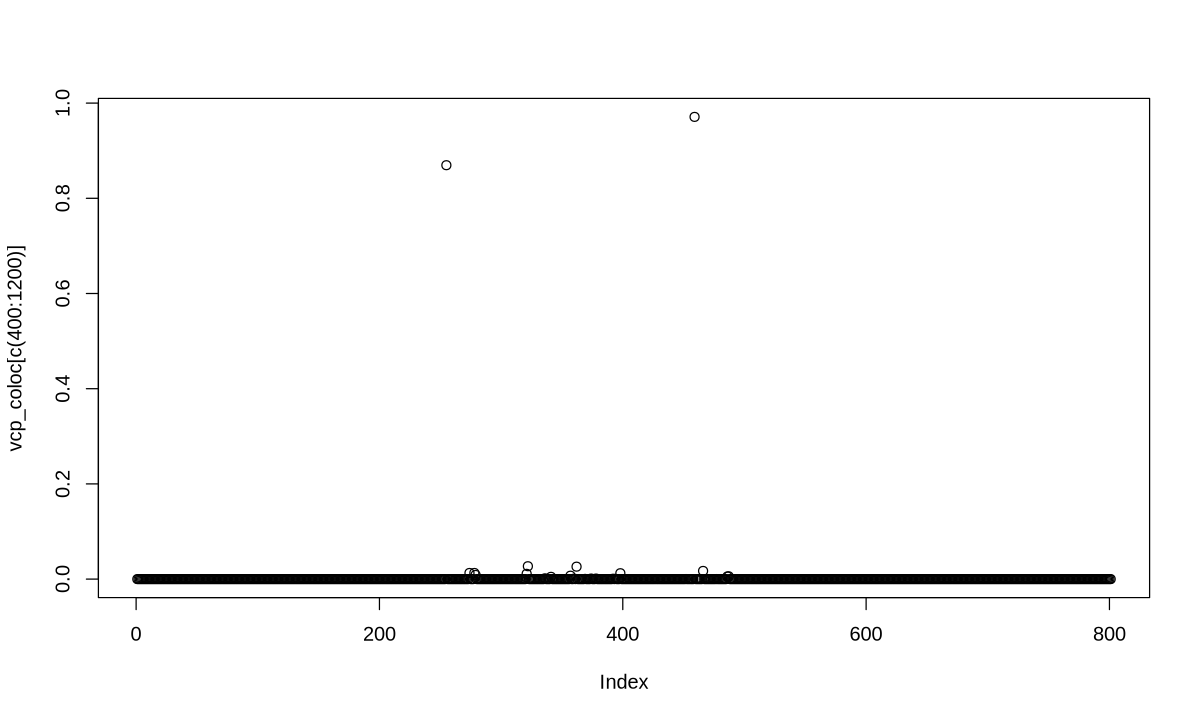

In [70]:
vcp_coloc <- 1 - (1-out_coloc$results$SNP.PP.H4.row2)*(1-out_coloc$results$SNP.PP.H4.row3)
plot(vcp_coloc[c(400:1200)])

### MOLOC

In [73]:
library(moloc)
moloc_input <- lapply(1:2, function(cnt){
    tibble(SNP = 1:ncol(data$X), BETA = betas[,cnt],
           SE = sebetas[,cnt], N = nrow(data$X), MAF = MAF)
})
res_moloc <- moloc_test(listData = moloc_input)

Use default priors: 1e-04,1e-05

Mean estimated sdY from data1: 0.553434902059988

Mean estimated sdY from data2: 0.553187001637554

Use prior variances of 0.01 0.1 0.5

Use prior variances of 0.01 0.1 0.5

Best SNP per trait a: 721

Probability that trait a colocalizes with at least one other trait = 1

Best SNP per trait b: 721

Probability that trait b colocalizes with at least one other trait = 1

Best SNP per trait ab: 721

Probability that trait ab colocalizes with at least one other trait = 1



In [74]:
res_moloc$priors_lkl_ppa

,prior,sumbf,logBF_locus,PPA
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.00e-04,60.59171,52.90784,2.492328e-28
"a,b",1.00e-08,125.07877,109.71104,2.529180e-04
b,1.00e-04,65.56983,57.88597,3.618911e-26
ab,1.00e-05,126.45320,118.76934,9.997471e-01
zero,9.99e-01,0.00000,0.00000,1.207708e-50


In [75]:
res_moloc$best_snp

,coloc_ppas,best.snp.coloc
,<dbl>,<chr>
a,0.9997471,721
b,0.9997471,721
ab,0.9997471,721


## 3. Weaker causal effect for target traits

In [76]:
library(colocboost)
library(tidyverse)
load("data/Weaker_GWAS_Effect.rda")
data <- Weaker_GWAS_Effect
X <- data$X
Y <- data$Y
data$variant

[1] 1926 2271

In [77]:
res <- colocboost(X = X, Y = Y)
res$cos_details$cos$cos_index

Starting checking the input data.

Starting gradient boosting algorithm.

Boosting iterations for outcome 1 converge after 23 iterations!

Boosting iterations for outcome 2 converge after 33 iterations!

Starting assemble analyses and results summary.



$`cos1:y1_y2`
[1] 1926

$`cos2:y1_y2`
[1] 2271

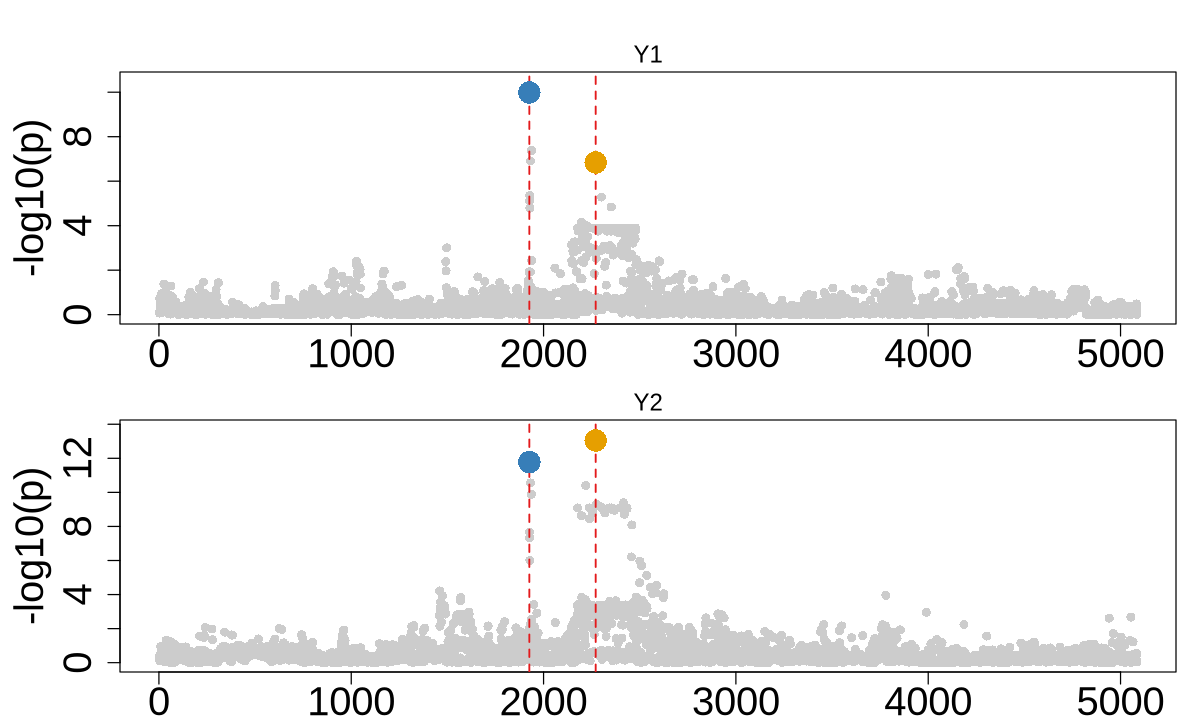

In [78]:
options(repr.plot.width = 10, repr.plot.height = 6)
colocboost_plot(res, plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant))

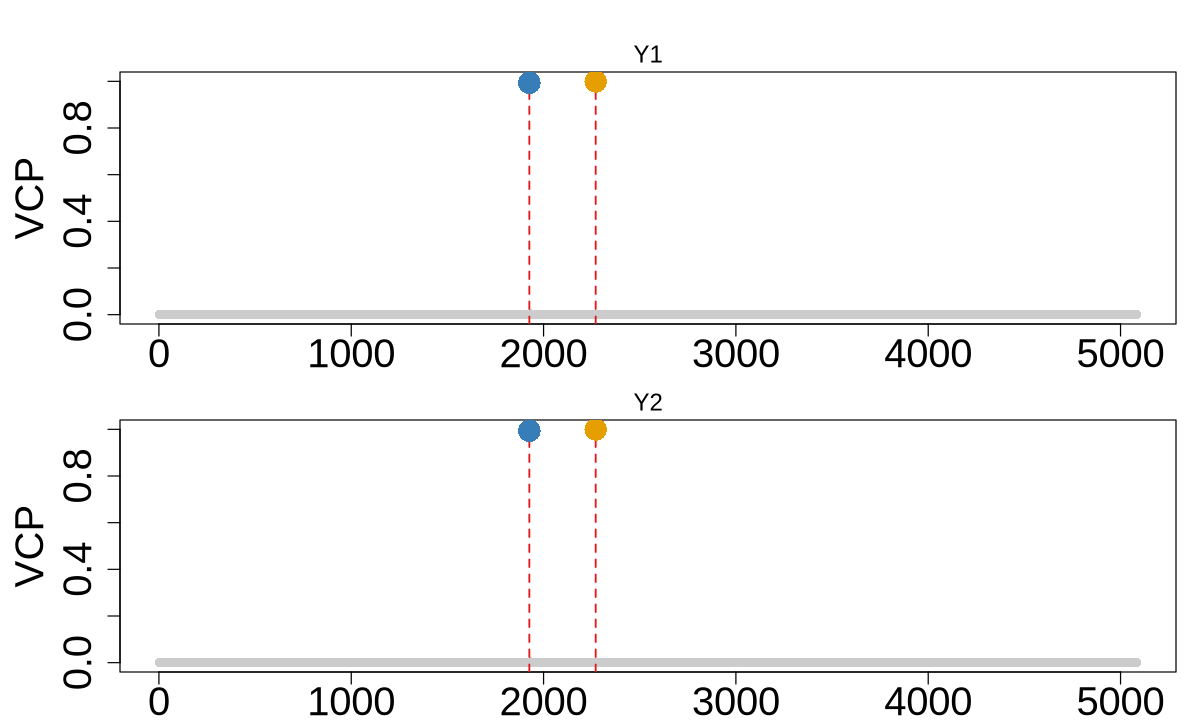

In [79]:
colocboost_plot(res, y = "vcp", plot_cols = 1, add_vertical = T, add_vertical_idx = c(data$variant))

### HyPrColoc

In [81]:
library(hyprcoloc)
betas = sebetas = matrix(NA, nrow = ncol(X), ncol = 2) 
for (i in 1:2){
    x <- scale(X)
    y <- scale(Y[,i])
    rr <- susieR::univariate_regression(x, y)
    betas[,i] = rr$betahat
    sebetas[, i] <- rr$sebetahat
}
traits <- c(1:2)
rsid <- paste0("snp", c(1:ncol(X)))
colnames(betas) <- colnames(sebetas) <- traits
rownames(betas) <- rownames(sebetas) <- rsid
res_hyprcoloc <- hyprcoloc(betas, sebetas, trait.names=traits, snp.id=rsid, snpscores = TRUE)

In [82]:
res_hyprcoloc$results

iteration,traits,posterior_prob,regional_prob,candidate_snp,posterior_explained_by_snp,dropped_trait
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
1,"1, 2",0.9616,1,snp1926,0.9823,NA


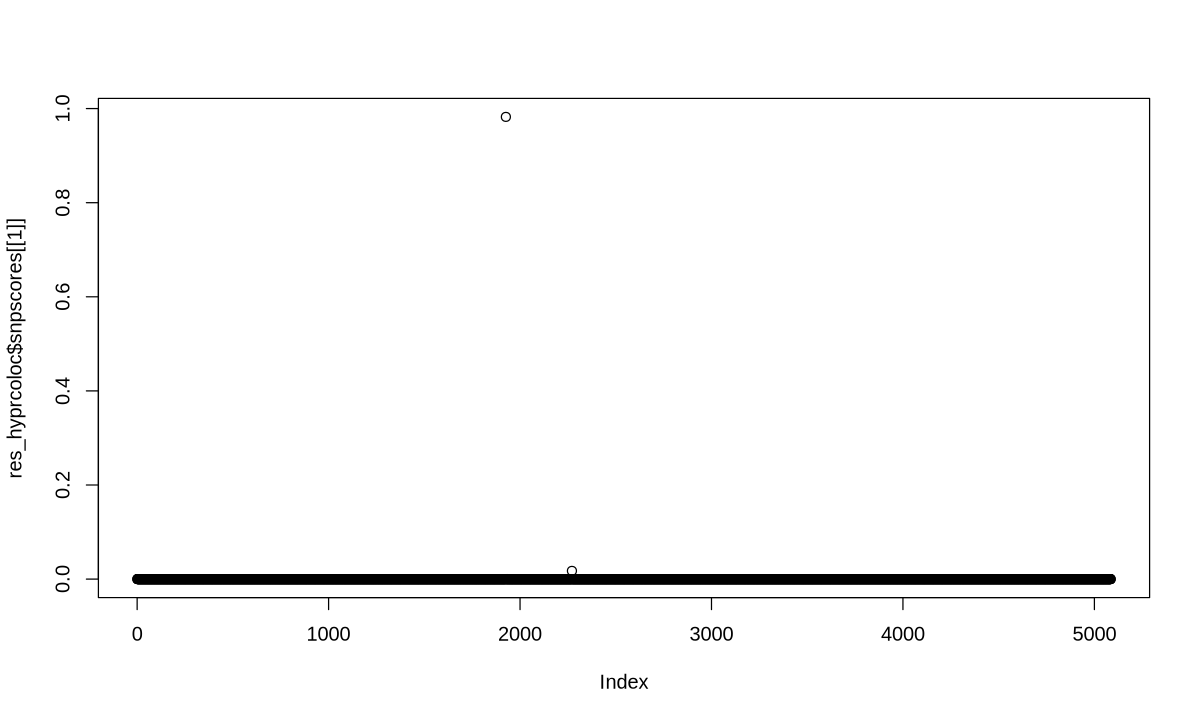

In [83]:
plot(res_hyprcoloc$snpscores[[1]])

### COLOC (one causal assumption)

In [86]:
library(coloc)
LD <- get_cormat(data$X)
colnames(LD) <- rownames(LD) <- 1:ncol(data$X)
MAF <- colMeans(data$X)/2 %>% as.numeric
D1 <- list("beta" = betas[,1], "varbeta" = sebetas[,1]^2,
           "N" = nrow(data$X), "sdY" = sd(unlist(data$Y[,1])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(data$X), "position" = 1:ncol(data$X))
D2 <- list("beta" = betas[,2], "varbeta" = sebetas[,2]^2,
           "N" = nrow(data$X), "sdY" = sd(unlist(data$Y[,2])),
           "type" = 'quant', "MAF" = MAF, "LD" = LD,
           "snp" = 1:ncol(data$X), "position" = 1:ncol(data$X))
my.res <- coloc.abf(dataset1=D1, dataset2=D2)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 3.94e-13  2.65e-09  2.69e-06  1.71e-02  9.83e-01 
[1] "PP abf for shared variant: 98.3%"


In [87]:
o <- order(my.res$results$SNP.PP.H4,decreasing=TRUE)
cs <- cumsum(my.res$results$SNP.PP.H4[o])
w <- which(cs > 0.95)[1]
my.res$results[o,][1:w,]$snp

[1] "1926"

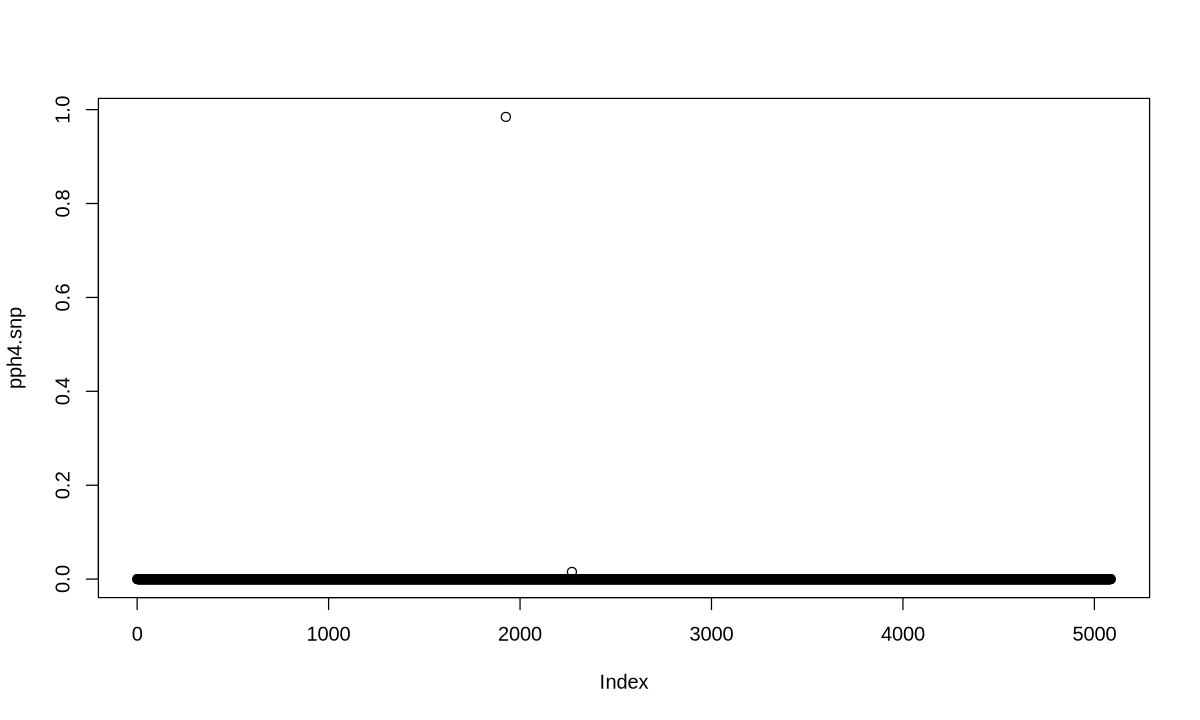

In [88]:
pph4.snp <- my.res$results$SNP.PP.H4[order(my.res$results$position,decreasing=FALSE)]
plot(pph4.snp)

### COLOC (V5)

In [91]:
library(susieR)
out_p <- runsusie(D1)
out_e <- runsusie(D2)
out_coloc = coloc.susie(out_e, out_p)

running max iterations: 100

	converged: TRUE

running max iterations: 100

	converged: TRUE



In [92]:
out_coloc$summary

In [93]:
o <- order(out_coloc$results$SNP.PP.H4.row2,decreasing=TRUE)
cs <- cumsum(out_coloc$results$SNP.PP.H4.row2[o])
w <- which(cs > 0.95)[1]
cos1 <- out_coloc$results[o,][1:w,]$snp
cos1

[1] "1926"

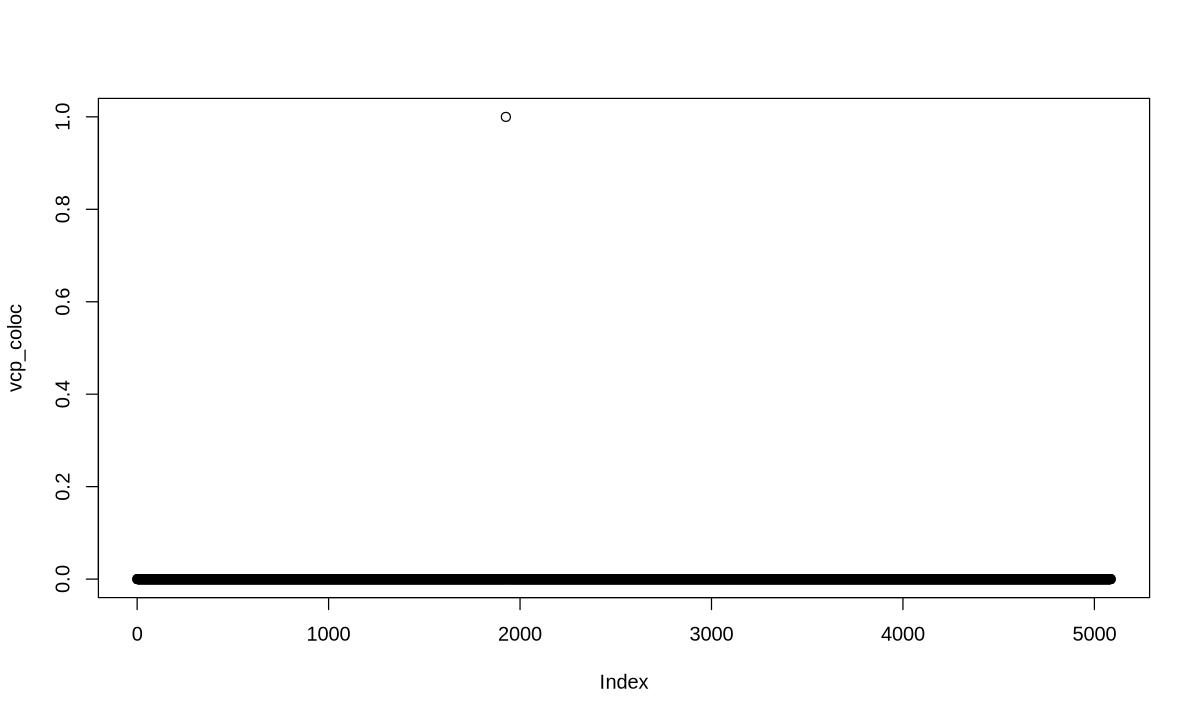

In [94]:
vcp_coloc <- out_coloc$results$SNP.PP.H4.row2
plot(vcp_coloc)

### MOLOC

In [96]:
library(moloc)
moloc_input <- lapply(1:2, function(cnt){
    tibble(SNP = 1:ncol(data$X), BETA = betas[,cnt],
           SE = sebetas[,cnt], N = nrow(data$X), MAF = MAF)
})
res_moloc <- moloc_test(listData = moloc_input)

Use default priors: 1e-04,1e-05

Mean estimated sdY from data1: 0.537763795330779

Mean estimated sdY from data2: 0.537609105700604

Use prior variances of 0.01 0.1 0.5

Use prior variances of 0.01 0.1 0.5

Best SNP per trait a: 1926

Probability that trait a colocalizes with at least one other trait = 0.99

Best SNP per trait b: 1926

Probability that trait b colocalizes with at least one other trait = 0.99

Best SNP per trait ab: 1926

Probability that trait ab colocalizes with at least one other trait = 0.99



In [97]:
res_moloc$priors_lkl_ppa

,prior,sumbf,logBF_locus,PPA
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.00e-04,17.99025,9.456204,1.984014e-09
"a,b",1.00e-08,42.71907,25.650974,1.089268e-02
b,1.00e-04,24.81574,16.281686,1.827317e-06
ab,1.00e-05,40.32003,31.785978,9.891055e-01
zero,9.99e-01,0.00000,0.000000,3.051242e-13


In [98]:
res_moloc$best_snp

,coloc_ppas,best.snp.coloc
,<dbl>,<chr>
a,0.9891055,1926
b,0.9891055,1926
ab,0.9891055,1926
